# NEW BUILD of transit fitting pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from archeopteryx.constants import *
from archeopteryx.utils import *
from archeopteryx.Planet import *
from archeopteryx.LiteCurve import *
import archeopteryx.io as io
import archeopteryx.detrend as detrend
import archeopteryx.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters

In [2]:
# target (KOI number in format 'Kxxxxx') and csv file
TARGET   = 'K00137'

# primary directory
PRIMARY_DIR = '/Users/research/github/archeopteryx/'

# directory in which to place MAST_downloads, Figures, & Traces
DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
FIGURE_DIR   = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR    = PRIMARY_DIR + 'Traces/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
# CSV file for input
CSV_FILE = PRIMARY_DIR + 'Catalogues/pure_cks2.csv'

# Read in planet and stellar parameters from Kepler/Gaia

In [3]:
# READ IN THE DATA FROM CSV FILE
print('Reading in data from csv file')

# make a target name lightkurve and MAST can understand
MAST_TARGET = 'KOI-'+ str(int(TARGET[1:]))

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['id_starname']) == TARGET

KIC    = np.array(target_dict['id_kic'], dtype='int')[use]
NPL    = np.array(target_dict['koi_count'], dtype='int')[use]
RSTAR  = np.array(target_dict['iso_srad'],  dtype='float')[use]
MSTAR  = np.array(target_dict['iso_smass'], dtype='float')[use]

PERIODS = np.array(target_dict['koi_period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['koi_time0'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833
RADII   = np.array(target_dict['koi_prad'], dtype='float')[use]
DURS    = np.array(target_dict['koi_duration'], dtype='float')[use]/24         # [hrs] --> [days]

# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

# initialize with SOLAR limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# put epochs in range (0,period)
for npl in range(NPL):
    EPOCHS[npl] = EPOCHS[npl] % PERIODS[npl]
    
# convert radii to units of STELLAR radius (ie rp/Rstar)
RADII = RADII / RSRE * RSTAR

Reading in data from csv file


# Initialize Planet objects

In [4]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.radius   = RADII[npl]
    p.depth    = RADII[npl]**2
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # list of ttv parameters - [Amp, Pttv, phi, c0, c1, c2, c3]
    p.pttv = np.array([1e-5, 512., pi/2, 1e-5, 1e-5, 1e-5, 1e-5])
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, 1600., p.period)
    
    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # update index and epoch to be centered on dataset
    p.index -= int(np.median(p.index))
    p.epoch = p.tts[p.index==0][0]
        
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 3 Planet objects


# Download data from MAST

In [5]:
lc_qlist = np.arange(18)

# download the LONG CADENCE data -- this creates a LightCurveFileCollection
print('downloading long cadence data from MAST')
lc_rawdata = lk.search_lightcurvefile(MAST_TARGET, cadence='long', quarter=lc_qlist, \
                                      mission='Kepler').download_all(download_dir=DOWNLOAD_DIR)    

downloading long cadence data from MAST


# Detrend the lightcurves

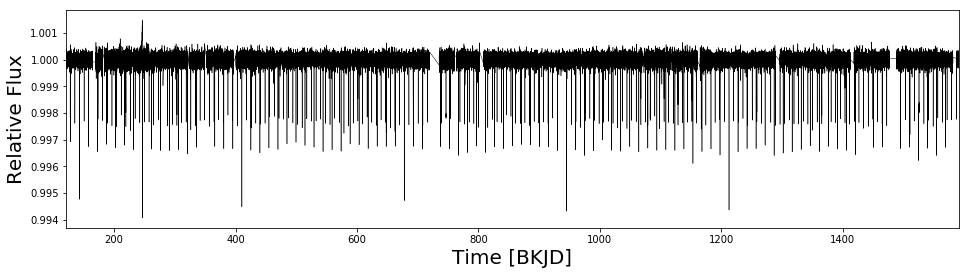

In [6]:
# clean up the LONG CADENCE data
lc_data = io.cleanup_lkfc(lc_rawdata, KIC)


# create masks where any planet transits
for i, lcq in enumerate(lc_data):
    lcq.transit_mask = np.zeros_like(lcq.time, dtype='bool')
    
    for npl in range(NPL):
        lcq.transit_mask += detrend.make_transitmask(lcq.time, planets[npl].tts, planets[npl].duration)
        
        
# determine smoothing kernel based on shortest transit duration
kernel_size = int(DURS.min()/(LCIT/60/24))
kernel_size += kernel_size % 2 + 1

# do some basic detrending
for i, lcq in enumerate(lc_data):
    lcq = detrend.detrend_single_quarter(lcq, window_length=101, break_tolerance=25, polyorder=2, \
                                         kernel_size=kernel_size, sigma_upper=5.0, sigma_lower=10.0)
    
    lc_data[i] = lcq
    
    
# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))
    
    
# combine into a single LightCurve
lc = detrend.stitch_lkc(lc_data)

# determine seasons
lc.season = lc.quarter % 4

plt.figure(figsize=(16,4))
plt.plot(lc.time, lc.flux, c='k', lw=0.5)
plt.xlim(lc.time.min(), lc.time.max())
plt.xlabel('Time [BKJD]', fontsize=20)
plt.ylabel('Relative Flux', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
plt.show()

# Make individual mask for where each planet transits

In [7]:
print('Making transit masks')
lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')

# create masks where any planet transits
for npl, p in enumerate(planets):
    lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
# add to LightCurves
lc.mask = lc_mask

Making transit masks


# Flag where there is data near transit (quality = 1)

In [8]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        neartransit = np.abs(lc.time - t0)/p.duration < 1.5
        quality.append(np.sum(neartransit) > 0)
        
    p.quality = quality

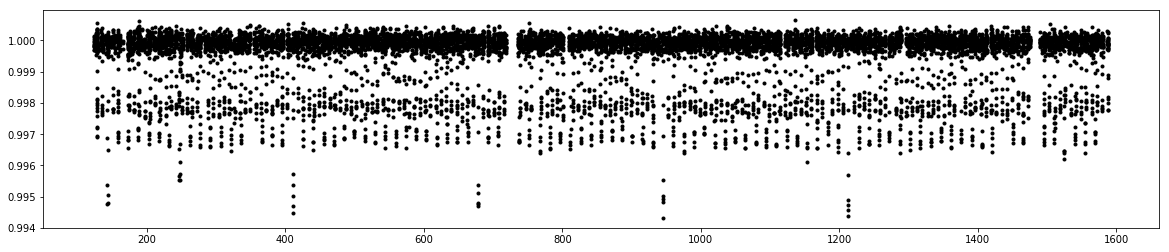

In [9]:
# use only flux near transits
lcm = lc.mask.sum(axis=0) > 0


lc_time = lc.time[lcm]
lc_flux = lc.flux[lcm]
lc_error = lc.error[lcm]
lc_cadno = lc.cadno[lcm]

plt.figure(figsize=(20,4))
plt.plot(lc_time, lc_flux, 'k.')
plt.show()

In [10]:
# pull basic transit parameters
epochs  = np.zeros(NPL)
periods = np.zeros(NPL)
radii   = np.zeros(NPL)
impacts = np.zeros(NPL)
durs    = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]  = p.epoch
    periods[npl] = p.period
    radii[npl]   = p.radius
    impacts[npl] = p.impact
    durs[npl]    = p.duration

# (1) Fit a transit model with polynomial TTVs

The TTV model is built as perturbations from a fixed Keplerian ephemeris. This ephemeris ("kep_ephemeris") is first caluated from the linear least squares fit epoch and period and is NOT varied during model fitting. Long-term, secular TTVs are parameterized as 3rd order Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

In [11]:
print('\n(1) Fitting POLYNOMIAL TTV model')


(1) Fitting POLYNOMIAL TTV model


In [12]:
# pull transit_inds (zero indexed) and calculate initial Keplerian ephemeris
transit_inds  = []
kep_ephemeris = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    kep_ephemeris.append((p.epoch + p.index*p.period)[p.quality])
    
    
    transit_inds[npl] -= transit_inds[npl].min()

In [13]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a Kepler baseline (0,1600) -- TODO: make baseline flexible for K2/TESS
for npl, p in enumerate(planets):    
    t.append(kep_ephemeris[npl])
    x = (2*t[npl]-1600)/1600

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [14]:
with pm.Model() as poly_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)   
    
    # polynomial TTV parameters
    C0 = pm.Normal('C0', mu=0.0, sd=1e-4, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=1e-4, shape=NPL)

    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              kep_ephemeris[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp, t=lc_time)
    summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(lc_time))
    model_flux = pm.Deterministic('model_flux', summed_light_curve)


    # add custom potential (log-prob fxn) with the GP likelihood
    obs = pm.Normal('obs', mu=model_flux, sd=lc_error, observed=lc_flux)

In [15]:
with poly_model:
    poly_map = exo.optimize(start=poly_model.test_point, vars=[flux0])
    poly_map = exo.optimize(start=poly_map, vars=[b])
    poly_map = exo.optimize(start=poly_map, vars=[u, Mstar])
    poly_map = exo.optimize(start=poly_map, vars=[C0, C1])
    poly_map = exo.optimize(start=poly_map)

optimizing logp for variables: [flux0]
54it [00:02, 25.03it/s, logp=3.362783e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 24948.23474759188 -> 33627.83469759176
optimizing logp for variables: [b, logr, Rstar]
194it [00:02, 78.86it/s, logp=6.437630e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 33627.83469759176 -> 64376.29823691348
optimizing logp for variables: [Mstar, u]
116it [00:01, 61.27it/s, logp=6.438735e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 64376.29823691348 -> 64387.35449254479
optimizing logp for variables: [C1, C0]
25it [00:01, 22.24it/s, logp=6.445205e+04]
message: Optimization terminated successfully.
logp: 64387.35449254479 -> 64452.051963322156
optimizing logp for variables: [C1, C0, flux0, b, logr, Mstar, Rstar, u]
213it [00:02, 76.11it/s, logp=6.934840e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 64452.051963322156

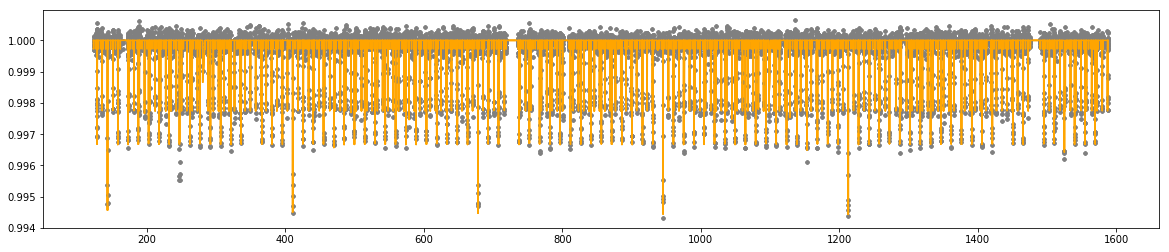

In [16]:
plt.figure(figsize=(20,4))
for i in range(4):
    plt.plot(lc_time, lc_flux, '.', color='grey')
    plt.plot(lc_time, poly_map['model_flux'], color='orange')
plt.show()

In [17]:
poly_transit_times = []
poly_ephemeris = []

for npl, p in enumerate(planets):
    poly_transit_times.append(poly_map['tts_{0}'.format(npl)])
    poly_ephemeris.append(poly_map['P'][npl]*transit_inds[npl] + poly_map['T0'][npl])

# (2) Fit independent TTVs

In [18]:
print('\n(2) Fitting INDEPENDENT TTV model')


(2) Fitting INDEPENDENT TTV model


In [19]:
rp   = poly_map['rp']
b = poly_map['b']

Rstar = poly_map['Rstar']
Mstar = poly_map['Mstar']
u = poly_map['u']

In [20]:
def build_indep_model(kep_ephemeris, transit_inds, lc_time, lc_flux, lc_error, durs):
    with pm.Model() as indep_model:
        # nuisance parameters
        flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)   

        # individual TTV parameters
        tt_offset = []
        transit_times = []

        for npl in range(NPL):
            tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0.0, sd=durs[npl]/2, \
                                       shape=len(kep_ephemeris[npl])))

            transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                                  kep_ephemeris[npl] + tt_offset[npl]))


        # set up stellar model and planetary orbit
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                     b=b, r_star=Rstar, m_star=Mstar)


        # track period and epoch
        T0 = pm.Deterministic('T0', orbit.t0)
        P  = pm.Deterministic('P', orbit.period)


        light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp, t=lc_time)
        summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(lc_time))
        model_flux = pm.Deterministic('model_flux', summed_light_curve)


        # add custom potential (log-prob fxn) with the GP likelihood
        obs = pm.Normal('obs', mu=model_flux, sd=lc_error, observed=lc_flux)
        
        return indep_model

In [21]:
results = []

for q in range(2,18):
    print('QUARTER {0}'.format(q))
    # use only flux near transits
    lcm = (lc.mask.sum(axis=0) > 0) * (lc.quarter == q)


    lc_time = lc.time[lcm]
    lc_flux = lc.flux[lcm]
    lc_error = lc.error[lcm]
    lc_cadno = lc.cadno[lcm]

    #plt.figure(figsize=(20,4))
    #plt.plot(lc_time, lc_flux, 'k.')
    #plt.show()    

    
    # pull transit_inds (zero indexed) and calculate initial Keplerian ephemeris
    transit_inds  = []
    kep_ephemeris = []

    for npl, p in enumerate(planets):
        transit_inds.append((p.index - p.index.min())[p.quality])
        kep_ephemeris.append((p.epoch + p.index*p.period)[p.quality])
        
        keep = (kep_ephemeris[npl] >= lc_time.min())*(kep_ephemeris[npl] <= lc_time.max())
        
        transit_inds[npl] = transit_inds[npl][keep]
        kep_ephemeris[npl] = kep_ephemeris[npl][keep]
        
        transit_inds[npl] -= transit_inds[npl].min()
    
    
    # build the model
    indep_model = build_indep_model(kep_ephemeris, transit_inds, lc_time, lc_flux, lc_error, durs)

    
    # get MAP solution
    with indep_model:
        indep_map = exo.optimize(start=indep_model.test_point)    
        
    indep_transit_times = []
    indep_ephemeris = []

    for npl in range(NPL):
        indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
        indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])
    
    # sample from the posteriors
    with indep_model:
        indep_trace = pm.sample(tune=2500, draws=1000, start=indep_map, chains=2, \
                          step=exo.get_dense_nuts_step(target_accept=0.9))
    
    
    results.append(indep_trace)

QUARTER 2


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
285it [00:01, 185.72it/s, logp=3.465772e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3378.82783135435 -> 3465.7715403808397
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [05:43<00:00, 20.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 3


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
175it [00:01, 142.11it/s, logp=4.402502e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4302.579084605518 -> 4402.502336130704
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [03:52<00:00, 30.14draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 4


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
205it [00:01, 160.15it/s, logp=4.676098e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4608.694538200458 -> 4676.0975482883
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [02:43<00:00, 42.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


QUARTER 5


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
252it [00:01, 162.94it/s, logp=4.932829e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4871.125641366041 -> 4932.829450656232
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [03:39<00:00, 31.86draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 6


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
153it [00:01, 127.06it/s, logp=4.934234e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4814.792242212613 -> 4934.234091828804
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [02:45<00:00, 44.43draws/s]


QUARTER 7


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
221it [00:02, 94.43it/s, logp=4.637226e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 4578.09072308296 -> 4637.225884919915
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:22<00:00, 26.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 8


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
212it [00:01, 141.60it/s, logp=3.456577e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3417.5813929926103 -> 3456.57732682745
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [03:18<00:00, 39.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 9


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
199it [00:01, 134.92it/s, logp=5.103145e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4970.236938688024 -> 5103.145295241695
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:47<00:00, 24.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 10


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
260it [00:01, 198.10it/s, logp=4.919384e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4868.858223894428 -> 4919.38367841462
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [03:57<00:00, 22.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 11


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
230it [00:01, 158.77it/s, logp=5.292005e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 5235.419447287226 -> 5292.005070282255
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [02:48<00:00, 41.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 12


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
225it [00:01, 151.19it/s, logp=3.901996e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 3810.8033519910487 -> 3901.995616180961
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:29<00:00, 25.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 13


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
342it [00:01, 183.91it/s, logp=4.715917e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4667.021103909188 -> 4715.9171632116295
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [05:14<00:00, 22.27draws/s]
The acceptance probability does not match the target. It is 0.8021892411090096, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 14


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
196it [00:01, 142.04it/s, logp=4.996547e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4935.061767167798 -> 4996.546927413103
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [02:50<00:00, 40.99draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 15


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
205it [00:01, 127.80it/s, logp=4.921115e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 4818.965376097076 -> 4921.115423372352
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:20<00:00, 26.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


QUARTER 16


optimizing logp for variables: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
142it [00:02, 59.29it/s, logp=3.906398e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 3863.774686336537 -> 3906.3981591595557
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [tt_offset_2, tt_offset_1, tt_offset_0, flux0]
Sampling 2 chains: 100%|██████████| 7000/7000 [04:07<00:00, 28.34draws/s]
The number of effective samples is smaller than 25% for some parameters.


QUARTER 17


ERROR (theano.gof.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.gof.opt): node: AdvancedSubtensor1(IncSubtensor{Inc;int64}.0, TensorConstant{(1,) of 0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Vari

ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Variable: id 6116167576 IncSubtensor{Inc;int64}.0
  Op IncSubtensor{Inc;int64}(IncSubtensor{Inc;int64}.0, Subtensor{int64}.0, Constant{-1})
  Value Type: <class 'NoneType'>
  Old Value

ERROR (theano.gof.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.gof.opt): node: AdvancedSubtensor1(IncSubtensor{Inc;int64}.0, TensorConstant{(1,) of 0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Vari

ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Variable: id 6116167576 IncSubtensor{Inc;int64}.0
  Op IncSubtensor{Inc;int64}(IncSubtensor{Inc;int64}.0, Subtensor{int64}.0, Constant{-1})
  Value Type: <class 'NoneType'>
  Old Value

ERROR (theano.gof.opt): node: AdvancedSubtensor1(IncSubtensor{Inc;int64}.0, TensorConstant{(1,) of 0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Variable: id 5717225256 IncSubtensor{Inc;int64}.0
  Op IncSubtensor{Inc;int64}(In

ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Variable: id 5717225256 IncSubtensor{Inc;int64}.0
  Op IncSubtensor{Inc;int64}(IncSubtensor{Inc;int64}.0, Subtensor{int64}.0, Constant{-1})
  Value Type: <class 'NoneType'>
  Old Value:  None
  New Value:  None
  Reason

ERROR (theano.gof.opt): Optimization failure due to: local_useless_subtensor
ERROR (theano.gof.opt): node: AdvancedSubtensor1(IncSubtensor{Inc;int64}.0, TensorConstant{(1,) of 0})
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/opt.py", line 2074, in process_node
    remove=remove)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 569, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/toolbox.py", line 518, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/Users/research/anaconda3/lib/python3.7/site-packages/theano/gof/fg.py", line 486, in replace
    ". The type of the replacement must be the same.", old, new)
theano.gof.toolbox.BadOptimization: BadOptimization Error 
  Vari

In [26]:
results_copy = np.copy(results)

In [123]:
results = results_copy[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]

In [124]:
tts_med_0 = []
tts_med_1 = []
tts_med_2 = []

tts_std_0 = []
tts_std_1 = []
tts_std_2 = []

for q in range(len(results)):
    tts_med_0.append(np.median(results[q]['tts_0'], axis=0))
    tts_med_1.append(np.median(results[q]['tts_1'], axis=0))
    tts_med_2.append(np.median(results[q]['tts_2'], axis=0))

    tts_std_0.append(np.std(results[q]['tts_0'], axis=0))
    tts_std_1.append(np.std(results[q]['tts_1'], axis=0))
    tts_std_2.append(np.std(results[q]['tts_2'], axis=0))
    
tts_med_0 = np.hstack(tts_med_0)
tts_med_1 = np.hstack(tts_med_1)
tts_med_2 = np.hstack(tts_med_2)

tts_std_0 = np.hstack(tts_std_0)
tts_std_1 = np.hstack(tts_std_1)
tts_std_2 = np.hstack(tts_std_2)

tts_med = [tts_med_0, tts_med_1, tts_med_2]
tts_std = [tts_std_0, tts_std_1, tts_std_2]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [165]:
# get transit times and ephemeris

tts_ind = []

for npl, p in enumerate(planets):
    dummy = tts_med[npl] - p.epoch
    dummy -= dummy.min()
    dummy /= p.period
    
    dummy -= dummy[len(dummy)//2-1]
    
    tts_ind.append(np.rint(dummy))
    
    
tts_ephemeris = []

for npl, p in enumerate(planets):
    tts_ephemeris.append((p.epoch + tts_ind[npl]*p.period))

In [166]:
len(tts_ephemeris[1]), len(tts_med[1])

(161, 161)

0
1
2


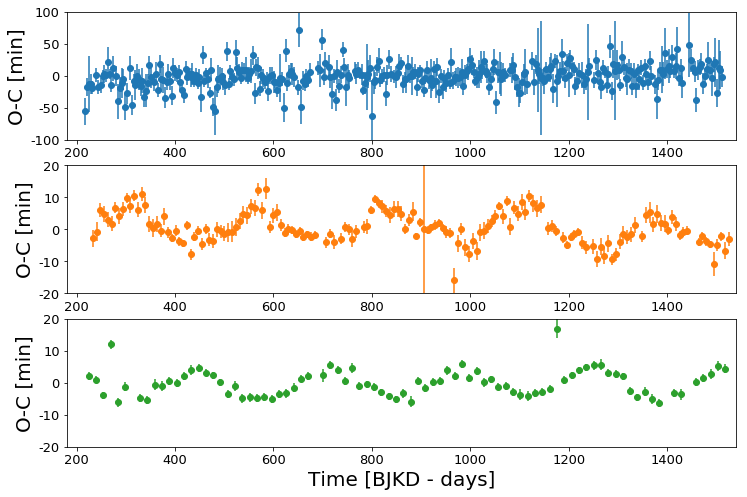

In [168]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    print(npl)
    xtime = tts_ephemeris[npl] + 67                            # +67 puts things in BKJD
    yomc  = (tts_med[npl] - tts_ephemeris[npl])*24*60
    yomc -= np.median(yomc)
    yerr  = tts_std[npl]*24*60
    
    axes[npl].errorbar(xtime, yomc, yerr=yerr, fmt='o', color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    axes[npl].set_xlim(180,1540)
    axes[npl].set_xticks(np.arange(200,1600,200))
    axes[npl].set_xticklabels(np.arange(200,1600,200), fontsize=13)
axes[NPL-1].set_xlabel('Time [BJKD - days]', fontsize=20)

axes[0].set_ylim(-80,80)
axes[1].set_ylim(-20,20)
axes[2].set_ylim(-20,20)

axes[0].set_yticks(np.arange(-100,120,50))
axes[0].set_yticklabels(np.arange(-100,120,50), fontsize=13)
axes[1].set_yticks(np.arange(-20,30,10))
axes[1].set_yticklabels(np.arange(-20,30,10), fontsize=13)
axes[2].set_yticks(np.arange(-20,30,10))
axes[2].set_yticklabels(np.arange(-20,30,10), fontsize=13)
plt.savefig('/Users/research/Desktop/K00137_long_cadence.pdf')
plt.show()

In [105]:
#np.save('/Users/research/Desktop/K00137_tts_med_0', tts_med_0)
#np.save('/Users/research/Desktop/K00137_tts_med_1', tts_med_1)
#np.save('/Users/research/Desktop/K00137_tts_med_2', tts_med_2)

#np.save('/Users/research/Desktop/K00137_tts_std_0', tts_std_0)
#np.save('/Users/research/Desktop/K00137_tts_std_1', tts_std_1)
#np.save('/Users/research/Desktop/K00137_tts_std_2', tts_std_2)

In [ ]:
#tts_med_0 = np.load('/Users/research/Desktop/K00137_tts_med_0.npy')
#tts_med_1 = np.load('/Users/research/Desktop/K00137_tts_med_1.npy')
#tts_med_2 = np.load('/Users/research/Desktop/K00137_tts_med_2.npy')

#tts_std_0 = np.load('/Users/research/Desktop/K00137_tts_std_0.npy')
#tts_std_1 = np.load('/Users/research/Desktop/K00137_tts_std_1.npy')
#tts_std_2 = np.load('/Users/research/Desktop/K00137_tts_std_2.npy')